# Analyse des résultats de la  prédiction

In [1]:
#récupération de l'ap de bigml

from bigml.api import BigML
from pandas import read_csv
from sklearn.metrics import confusion_matrix
import pandas as pan
import matplotlib.pyplot as plt
import random

In [2]:
#récupération des identifiants du projet de bigml

%env BIGML_USERNAME=damienthiberge
%env BIGML_API_KEY=d92377e535638e44239dc49238540477263e1bff

env: BIGML_USERNAME=damienthiberge
env: BIGML_API_KEY=d92377e535638e44239dc49238540477263e1bff


In [3]:
#charge de l'api bigml pour pouvoir faire appel à ces fonctions

api = BigML()

### récupération du fichier train full

In [4]:
#récupération du fichier csv bigml à traiter

train_full = api.create_source('../../handson-ml/jupiter/train_full.csv')

In [5]:
#test des sources

api.ok(train_full)

True

In [6]:
#création dataset depuis le fichier csv importer précédement

train_full_dataset = api.create_dataset(train_full)

### split du fichier train full afin d'entrainer la machine

In [7]:
#split du train full

train_dataset = api.create_dataset(
    train_full_dataset, {"name": "Train (80%)",
                     "sample_rate": 0.8, "seed": "Full train"})
validation_dataset = api.create_dataset(
    train_full_dataset, {"name": "Train (20%)",
                     "sample_rate": 0.8, "seed": "Full train",
                     "out_of_bag": True})

### création du model puis batch prédiction

In [8]:
#creation d'un ensemble à partir de train 

ensemble = api.create_ensemble([train_dataset],{"objective_field":"SeriousDlqin2yrs"})

In [9]:
#batch prédiction

batch_prediction = api.create_batch_prediction(ensemble, validation_dataset, {"all_fields":True, "probabilities":True})


In [10]:
#test prediction

api.ok(batch_prediction)

True

### récupération csv de la prédiction

In [11]:
#telechargement de la prédiction

api.download_batch_prediction(batch_prediction,
    filename='../../handson-ml/predictions_error.csv')

'../../handson-ml/predictions_error.csv'

In [12]:
error = read_csv('../../handson-ml/predictions_error.csv', index_col=0)
error

,Id,RevolvingUtilizationOfUnsecuredLines,age,IsOld,DebtRatio,MonthlyIncome,NumberOfTimes30DaysOrLater,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents,SeriousDlqin2yrs,SeriousDlqin2yrs.1,0 probability,1 probability
field1,,,,,,,,,,,,,,
5,6,0.213179,74,1,0.375607,3500.0,0,3,1,6,0,0,0.99575,0.00425
6,7,0.305682,57,0,5710.000000,NaN,0,8,3,7,0,0,0.98229,0.01771
12,13,0.010352,46,0,0.298354,12454.0,0,13,2,13,0,0,0.98627,0.01373
13,14,0.964673,40,0,0.382965,13700.0,14,9,1,14,1,1,0.38089,0.61911
20,21,0.200923,43,0,0.430046,12300.0,0,10,2,21,0,0,0.97725,0.02275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149969,149970,0.075535,43,0,0.197538,14700.0,0,10,3,149970,0,0,0.97782,0.02219
149974,149975,0.962721,61,0,0.603479,5000.0,2,11,1,149975,0,0,0.69149,0.30851
149983,149984,0.002485,82,1,0.000800,5000.0,0,5,0,149984,0,0,0.99709,0.00291


### mise en forme de la prédiction

In [13]:
# renomme la colonne 1 probability en prédiction
myList = list(error.columns)
myList[1] = 'Prediction'
error.columns = myList

In [14]:
error.to_csv("predictions_error.csv")

In [15]:
# création de la colonne error
error.insert( 2, 'Error', '')

In [16]:
# fonction de remplissage de la colonne error
def errorPred(row):
    if row['SeriousDlqin2yrs'] == 0 and row['Prediction'] == 0:
        row['Error'] = 'TN'
    if row['SeriousDlqin2yrs'] == 0 and row['Prediction'] == 1:
        row['Error'] = 'FP'
    if row['SeriousDlqin2yrs'] == 1 and row['Prediction'] == 0:
        row['Error'] = 'FN'
    if row['SeriousDlqin2yrs'] == 1 and row['Prediction'] == 1:
        row['Error'] = 'TP'
    return row


In [17]:
# remplissage de la colonne erreor
for df in [error]:
    df['Error'] = df[['Error', 'SeriousDlqin2yrs', 'Prediction']].apply(errorPred,axis=1)
    
error.to_csv("predictions_error.csv")

### calcul de la matrice de confusion, accurancy et gain

In [18]:
# affichage de la matrice de confusion
resultat = error['Error'].value_counts()
resultat

      27848
TN     2095
FN       56
FP        1
Name: Error, dtype: int64

In [19]:
# calcul de l'accurancy
accuracy = (resultat[0] + resultat[2])/(resultat[0] + resultat[1] + resultat[0] + resultat[3])
accuracy

0.48283499446290146

In [20]:
# calcul de la matrice de gain
matrice_gain = resultat[0]*500 - resultat[1]*500 + resultat[2]*0 - resultat[3]*2500
matrice_gain

12874000

### calcul gain en fonction d'une valeur seuil

In [21]:
# fonction de remplissage de la colonne error en prenant en compte une valeur seuil et retour du gain
def gain_seuil(seuil):
    def seuil_pred(row, seuil):
        if row['1 probability'] > seuil and row['SeriousDlqin2yrs'] == 0:
            row['Error'] = 'FP'
        if row['1 probability'] > seuil and row['SeriousDlqin2yrs'] == 1:
            row['Error'] = 'TP'
        if row['1 probability'] < seuil and row['SeriousDlqin2yrs'] == 0:
            row['Error'] = 'TN'
        if row['1 probability'] < seuil and row['SeriousDlqin2yrs'] == 1:
            row['Error'] = 'FN'
        return row

    for df in [error]:
        df['Error'] = df[['Error', '1 probability', 'SeriousDlqin2yrs']].apply(seuil_pred, axis=1, seuil = seuil)

    count = error['Error'].value_counts()
    gain = 1
    if "TP" not in  error['Error']:
        if "FP" not in  error['Error']:
            gain = count[0]*500 - count[1]*500
        else:
            gain = count[0]*500 - count[1]*2500 - count[3]*500
    else:
        gain = count[0]*500 - count[1]*500 - count[2]*2500
        
    return gain

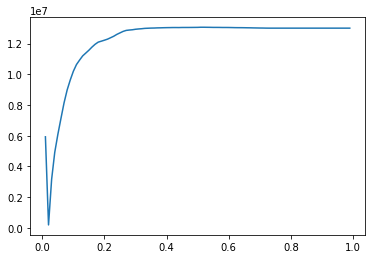

In [22]:
# affichage de la courbe de gzin en fonction de la valeur seuil
table = [gain_seuil(n/100) for n in range(1,100)]
seuil = [(n/100) for n in range(1,100)]
plt.plot(seuil, table)
plt.show()

In [23]:
#calcul de la valeur max du gain et obtention du seuil optimal
max_val = max(table)
max_seuil = table.index(max_val)/10

print(f"le gain maximal est de {max_val} et il est obtenu en {max_seuil}")

le gain maximum est de 13070000 et il est obtenu en 5.0
